In [1]:
import sys
import numpy as np
import librosa

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import os

# import chainer
# from chainer import cuda, Variable, Chain, serializers
# import chainer.functions as F
# import chainer.links as L

# sys.path.append('../networks/')
from network import *

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
logmel_Res = []
freqs = range(7995, 0, -10)
wav_len = int(16000 * 1.5)
fs = 16000 

for freq in freqs:
    response = np.zeros([80])
    x = np.array([np.sin(2.0 * np.pi * freq * i / fs) for i in range(wav_len)])
#     print x, len(x)
    melspec = librosa.feature.melspectrogram(x, 16000, n_fft=800, hop_length=160, n_mels=80) # (40, 151)
#     print melspec, melspec.shape
    logmel = librosa.logamplitude(melspec) # (40, 151)
#     print 'logmel: ', logmel, logmel.shape
    res = np.mean(logmel[:, 10: 140], axis=1) # (40,)
#     print 'res: ', res, res.shape
    logmel_Res.append(res)
#     break
logmel_Res = np.array(logmel_Res) # (800, 40)
print logmel_Res
print logmel_Res.shape
mel_freq = 7995 - 10 * np.argmax(logmel_Res, axis=0)
print mel_freq

[[-70.40442178 -70.40442178 -70.40442178 ..., -70.40442178 -62.43716988
    6.40404104]
 [-69.54754048 -69.54754048 -69.54754048 ..., -69.54754048 -62.19489079
   10.06603131]
 [-67.66984204 -67.66984204 -67.66984204 ..., -67.66984204 -62.62887352
   12.26345253]
 ..., 
 [ 30.00804989  16.04037925 -13.60995432 ..., -49.91581546 -49.91581546
  -49.91581546]
 [ 28.02864056   9.35573455 -17.46511465 ..., -51.56356719 -51.56356719
  -51.56356719]
 [ 24.45604052  -3.59050378 -20.82352896 ..., -52.32596015 -52.32596015
  -52.32596015]]
(800, 80)
[  35   75  115  145  185  225  265  295  335  375  405  445  485  525  555
  595  635  675  705  745  785  815  855  895  935  965 1005 1045 1085 1125
 1175 1215 1265 1315 1365 1425 1475 1535 1595 1655 1725 1785 1855 1935 2005
 2085 2165 2255 2345 2435 2525 2625 2725 2835 2945 3065 3185 3305 3435 3575
 3715 3855 4005 4165 4325 4495 4675 4855 5045 5245 5445 5665 5885 6115 6355
 6605 6865 7125 7405 7695]


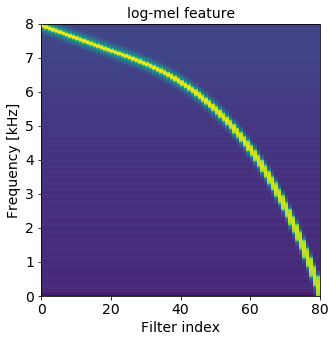

In [5]:
fig = plt.figure(figsize=(5, 5))

x, y = np.meshgrid(np.arange(81), np.arange(801) / 801. * 8) # (801, 41) (801, 41)
# print x.shape, y.shape
# print x
# print y
# plt.pcolor(x, y, np.flipud(logmel_Res)) # np.flipud 矩阵上下翻转
plt.pcolor(x, y, logmel_Res) # np.flipud 矩阵上下翻转
plt.title('log-mel feature', fontsize=14)
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

In [6]:
# Create sin waves

freqs = range(7995, 0, -10)
wav_len = int(16000 * 1.5+2)
fs = 16000
X = []

for freq in freqs:
    x = np.array([np.sin(2.0 * np.pi * freq * i / fs) for i in range(wav_len)])
    X.append(x[np.newaxis, :])
X = np.array(X).astype(np.float32) # (800, 1, 24002)
# print X
print X.shape

(800, 1, 24002)


In [28]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

model = torch.load('../model/waveLSTM_v3_epoch20.pkl')
model.cuda()

# print model
# Calculate pool2 of EnvNet
batchsize = 32
Res = []
N = 800

Xt = torch.from_numpy(X)
Xt = Xt.cuda()
Xt = Variable(Xt)
for i in xrange(0, N, batchsize):
#     print i
    x = Xt[i: i+batchsize]
    x = F.relu(model.conv1(x))   # (batchSize, 80L, 24001L)
    x = F.relu(model.pool1(x))   # (batchSize, 80L, 150L)
#     x = F.relu(model.conv2(x))   # (batchSize, 40L, 24000L)
#     pool2 = model.pool2(x)  # (batchSize, 40L, 150L)    
#     print pool2
#     res = np.average(pool2, axis=2)
    res = torch.mean(x, dim=2)
    Res.extend(res.data.cpu().numpy())

# print Res
Res = np.asarray(Res)
print Res.shape


(800, 80)


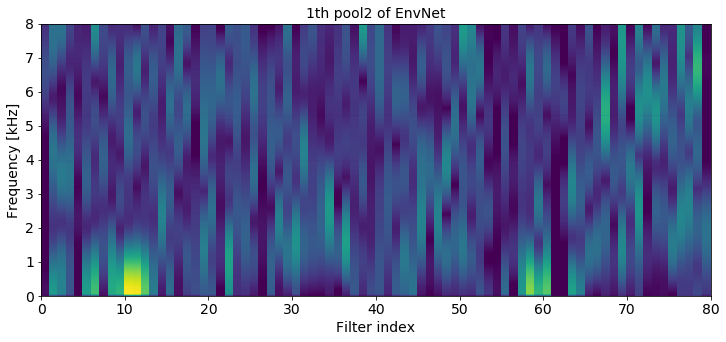

In [29]:
fig = plt.figure(figsize=(12, 5))


x, y = np.meshgrid(np.arange(81), np.arange(801) / 801. * 8)
plt.pcolor(x, y, np.flipud(Res))
plt.title('1th pool2 of EnvNet', fontsize=14)
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)


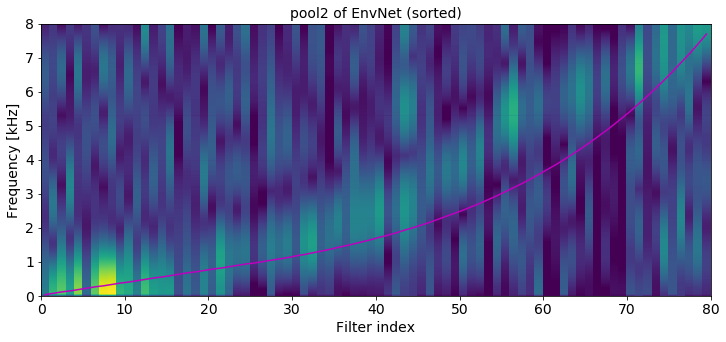

In [30]:
center_freq = 7995 - 10 * np.argmax(Res, axis=0)
# rm_index = [5, 6, 7, 8, 18] # filters which respond to all frequency area are removed
# center_freq[rm_index] = 8000
sort_index = np.argsort(center_freq)[:80]
sorted_Res = Res[:, sort_index]

fig = plt.figure(figsize=(12, 5))

x, y = np.meshgrid(np.arange(81), np.arange(801) / 801. * 8)
plt.pcolor(x, y, np.flipud(sorted_Res))
plt.plot(np.arange(80) * (80) / 80. + 0.5 , mel_freq / 1000., 'm')
plt.title('pool2 of EnvNet (sorted)', fontsize=14)
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)


In [34]:
np.savetxt('../figures/txt/response.txt', Res)
np.savetxt('../figures/txt/sorted_response.txt', sorted_Res)
np.savetxt('../figures/txt/logmel_response.txt', logmel_Res)
np.savetxt('../figures/txt/mel_freq.txt', mel_freq)